In [1]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from skimage import io
from skimage.util import view_as_windows
from keras.utils import np_utils
from PIL import Image, ImageDraw

sys.path.append('/home/tanuj/Workspace/power-grid-detection')

%matplotlib inline
Image.MAX_IMAGE_PIXELS = None

Using Theano backend.
Using gpu device 1: GeForce GTX 680 (CNMeM is disabled, cuDNN 5005)


In [2]:
import config

from utils.model.helpers import get_model_from_json
from utils.img.helpers import sliding_window
from utils.dataset.helpers import get_image_collection
from utils.img.collection import ImageCollection

/home/tanuj/.tools/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
model = get_model_from_json('cnn_140_1_thr_dil_ero_lr_0.100000_final.json')
model

In [4]:
model.load_weights('/home/tanuj/Workspace/power-grid-detection/training/cnn_140_1_thr_dil_ero_lr_0.100000_training_weights_best.hdf5')

In [19]:
raw_collection = get_image_collection(config.affixed_tiles_dir)
processed_collection = get_image_collection(config.preprocessed_tiles_dir)

In [8]:
# raw_collection = ImageCollection([])
# area_processed_collection = ImageCollection(['/home/tanuj/Workspace/power-grid-detection/dataset/test/processed/3.jpg'])

In [70]:
it = iter(range(100))

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [71]:
sample_no = next(it)

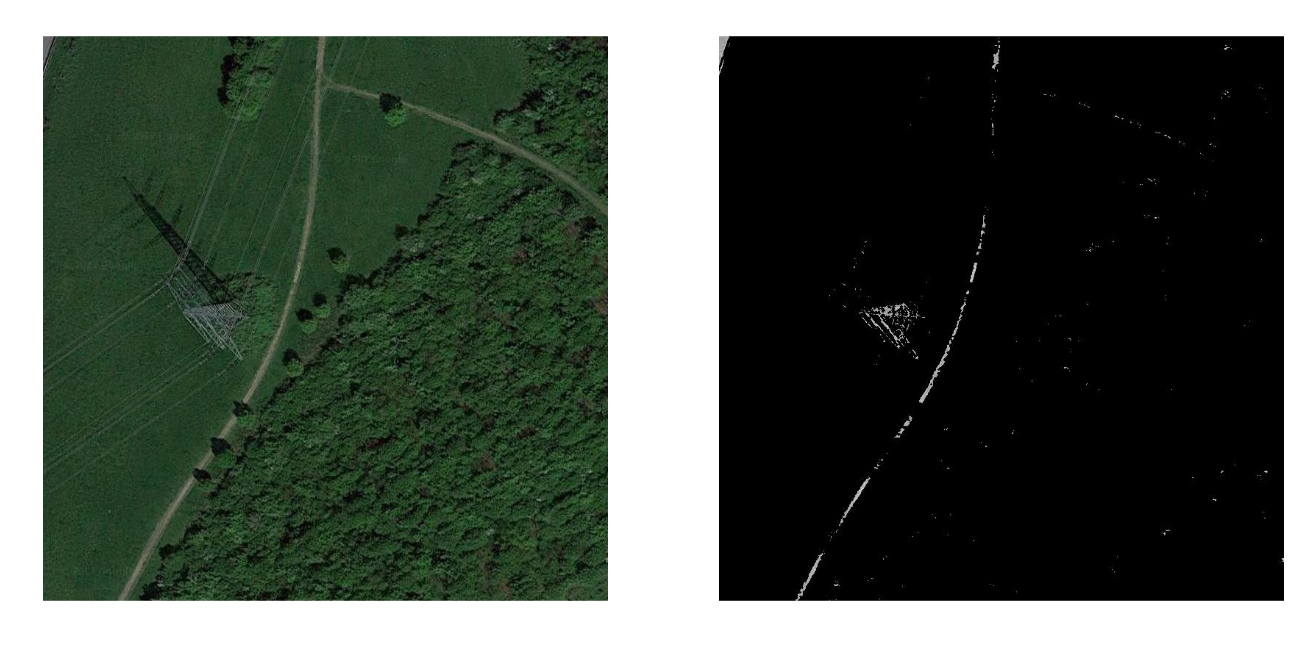

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', squeeze=True, figsize=(16, 8))
ax1.axis('off')
ax2.axis('off')

ax1.imshow(raw_collection[sample_no])
ax2.imshow(processed_collection[sample_no], cmap='gray')
plt.show()

In [73]:
window_size = (140, 140)
stride = (35, 35)

In [74]:
# image = area_processed_collection[0]
# image = image.reshape(image.shape[0], image.shape[1], 1)
image = processed_collection[sample_no]
# image = img.copy()

sw = view_as_windows(image, window_size, stride)
sw_shape = sw.shape

# fig, axes = plt.subplots(sw.shape[0], sw.shape[1], sharex='all', sharey='all', squeeze=True, figsize=(16, 16))

# for i in range(sw.shape[0]):
#     for j in range(sw.shape[1]):
#         axes[i, j].axis('off')
#         axes[i, j].imshow(sw[i, j])

# plt.show()


sw = sw.reshape((sw_shape[0] * sw_shape[1], sw_shape[2], sw_shape[3], 1))

predictions = model.predict(sw, batch_size=32, verbose=1)

# print(predictions)

# del image, sw

324/324 [==============================] - 1s     


In [75]:
# predictions

In [76]:
y = predictions.copy()
# y[y < 0.5] = 0
y = np_utils.categorical_probas_to_classes(y)
y = y.reshape(sw_shape[0], sw_shape[1])

In [77]:
y.shape
np.bincount(y.reshape((sw_shape[0] * sw_shape[1], )))

array([247,  77])

In [78]:
# im = Image.open('/home/tanuj/Workspace/power-grid-detection/dataset/test/3.jpg')

# drawable = ImageDraw.Draw(im)

# for i in range(sw_shape[0]):
#     for j in range(sw_shape[1]):
#         if y[i, j]:
#             drawable.rectangle(
#                 (i * stride[0], 
#                  j * stride[1], 
#                  i * stride[0] + window_size[0], 
#                  j * stride[1] + window_size[1]),
#                 outline='red'
#             )

# im.save('/home/tanuj/Workspace/power-grid-detection/dataset/test/3_res.jpg', 'JPEG')

In [90]:
sample_no = next(it)

324/324 [==============================] - 1s     


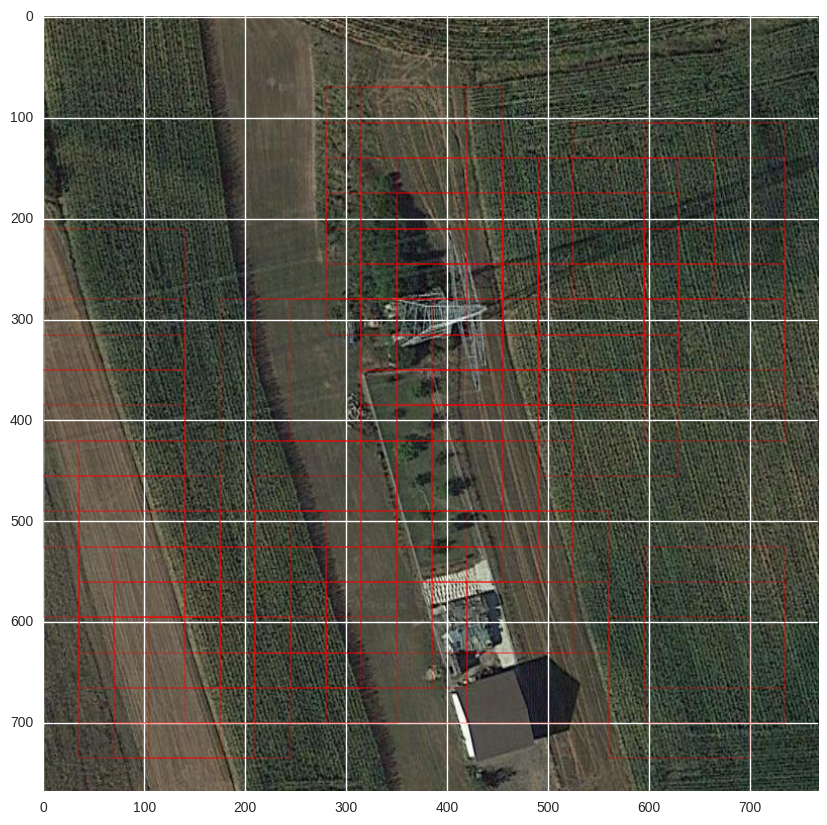

In [91]:
image = processed_collection[sample_no]

sw = view_as_windows(image, window_size, stride)
sw_shape = sw.shape

sw = sw.reshape((sw_shape[0] * sw_shape[1], sw_shape[2], sw_shape[3], 1))

predictions = model.predict(sw, batch_size=32, verbose=1)

fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(10, 10))

# ax.imshow(raw_collection[sample_no])
ax.imshow(raw_collection[sample_no])

for i in range(sw_shape[0]):
    for j in range(sw_shape[1]):
        if y[i, j]:
            patch = patches.Rectangle(
                (i * stride[0], j * stride[1]), 
                window_size[0],
                window_size[1],
                fill=False,
                edgecolor="red"
            )

            ax.add_patch(patch)
plt.show()

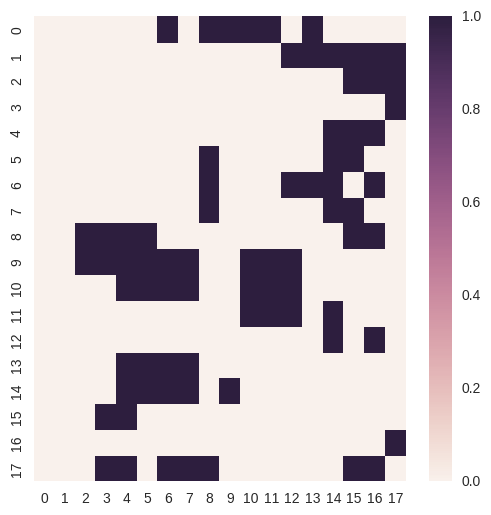

In [84]:
plt.figure(figsize=(6, 6))
ax = sns.heatmap(y)

plt.show()

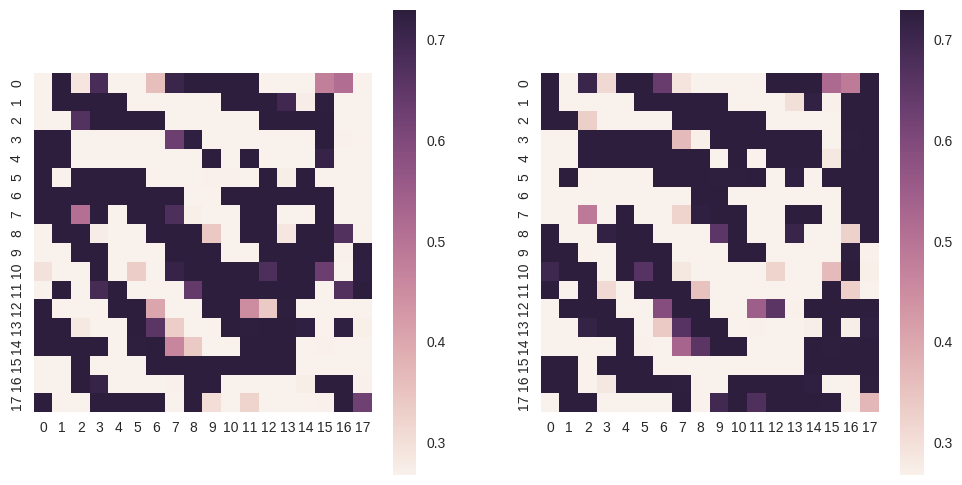

In [85]:
y_o = predictions[:, 0]
y_1 = predictions[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(y_o.reshape(sw_shape[0], sw_shape[1]), ax=ax1, square=True)
sns.heatmap(y_1.reshape(sw_shape[0], sw_shape[1]), ax=ax2, square=True)
plt.show()

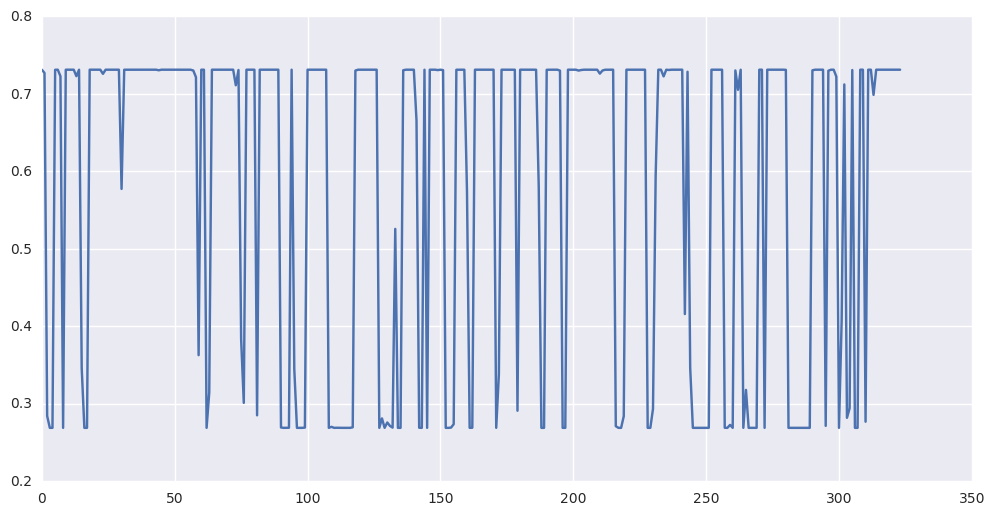

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(predictions[:, 1])